# L.Point Project
#### 20192796 이현준

In [1]:
# 사용하는 패키지
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import gc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [49]:
# 한글 폰트 사용하기
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)   

## 1. Data Cellection

In [3]:
# 데이터 불러오기
cs = pd.read_csv('L사_고객정보.csv')
gd = pd.read_csv('L사_상품정보.csv')
tr = pd.read_csv('L사_거래정보.csv')
log = pd.read_csv('L사_로그정보.csv')

C:\Users\Lee_HyeonJun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# cs, gd, tr 합치기
gd.pd_c = gd.pd_c.astype(str).str.zfill(4) 
df = pd.merge(tr, cs).merge(gd, on='pd_c')
df.de_dt = df.de_dt.astype(str).astype('datetime64')

## 2. Data Cleaning
#### 결측치 처리하기

In [5]:
df.isna().sum()

clnt_id         0
trans_id        0
trans_seq       0
biz_unit        0
pd_c            0
de_dt           0
de_tm           0
buy_am          0
buy_ct          0
clnt_gender     0
clnt_age        0
clac_nm1        0
clac_nm2        0
clac_nm3       26
dtype: int64

In [6]:
df = df.dropna()
df.isna().sum()

clnt_id        0
trans_id       0
trans_seq      0
biz_unit       0
pd_c           0
de_dt          0
de_tm          0
buy_am         0
buy_ct         0
clnt_gender    0
clnt_age       0
clac_nm1       0
clac_nm2       0
clac_nm3       0
dtype: int64

#### 이상치 처리하기

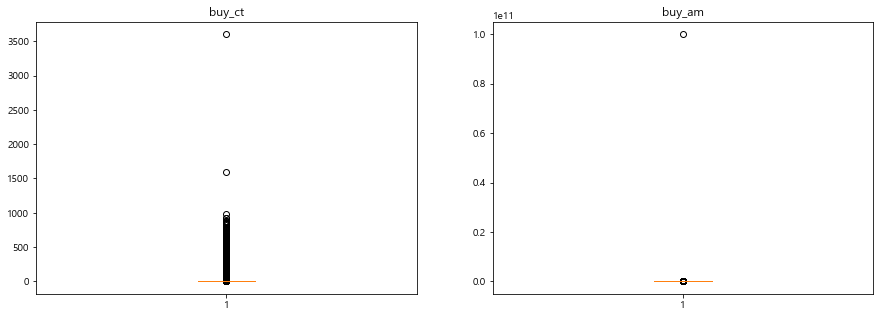

In [7]:
# 이상치 제거 전
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(df['buy_ct'])
plt.title('buy_ct')

plt.subplot(1,2,2)
plt.boxplot(df['buy_am'])
plt.title('buy_am')

plt.show()

In [8]:
df = df.query('buy_ct < 1000 and buy_am < 0.2*10**11')

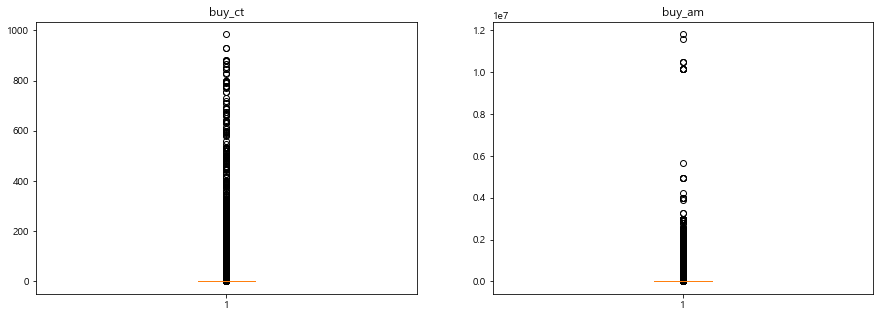

In [9]:
# 이상치 제거 후
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(df['buy_ct'])
plt.title('buy_ct')

plt.subplot(1,2,2)
plt.boxplot(df['buy_am'])
plt.title('buy_am')

plt.show()

In [10]:
# case-1에 대해서 통계자료를 보니 구매액이 대체로 크지 않은 편.구매건수가 1번이라고 볼 수 있는 금액이기에 이 값들을 1로 대체 
df['buy_ct'] = np.where(df.buy_ct == 0, 1, df.buy_ct)
# case-2과 case-3은 의미가 없는 경우라고 판단해 해당 레코드 삭제
df = df.query('buy_am != 0')

## Feature Generation

In [11]:
features = pd.DataFrame({'clnt_id': df.clnt_id.unique()});features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11265 entries, 0 to 11264
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   clnt_id  11265 non-null  int64
dtypes: int64(1)
memory usage: 88.1 KB


In [12]:
f = df.groupby('clnt_id')['buy_am'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액
0,21922,79980,13,6152,13900
1,39423,676262,134,5047,55600
2,18362,802720,117,6861,55600
3,48969,388898,100,3889,25800
4,18478,1998300,32,62447,711000
...,...,...,...,...,...
11260,15146,52800,1,52800,52800
11261,53632,77040,1,77040,77040
11262,58443,568000,1,568000,568000
11263,21232,362500,1,362500,362500


In [13]:
def drop_column_level(data):
    c_list = []
    for _, c in data.columns:
        if not c:
            c_list.append(_)
        else:
            c_list.append(c)
    return c_list

In [14]:
f = df.groupby('clnt_id').agg({
    'clac_nm3': [('구매상품수(소)', lambda x: x.nunique())],
    'clac_nm2': [('구매상품수(중)', lambda x: x.nunique())],
    'clac_nm1': [('구매상품수(대)', lambda x: x.nunique())]
}).reset_index()
f.columns = drop_column_level(f)
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대)
0,21922,79980,13,6152,13900,12,9,7
1,39423,676262,134,5047,55600,62,43,20
2,18362,802720,117,6861,55600,60,38,18
3,48969,388898,100,3889,25800,65,43,17
4,18478,1998300,32,62447,711000,21,16,13
...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1
11261,53632,77040,1,77040,77040,1,1,1
11262,58443,568000,1,568000,568000,1,1,1
11263,21232,362500,1,362500,362500,1,1,1


In [15]:
f = df.groupby('clnt_id')['de_dt'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: int(((x.max() - x.min()).days) / x.nunique())),
    ('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(2))
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03
...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00


In [16]:
visit_cnt = df.groupby('clnt_id')['trans_id'].agg(lambda x: x.nunique())
per_amount = (df.groupby('clnt_id')['buy_am'].sum() / visit_cnt).round(0).reset_index().rename(columns={0:'거래당구매액'})
per_count = (df.groupby('clnt_id')['buy_am'].count() / visit_cnt).round(1).reset_index().rename(columns={0:'거래당구매건수'})
f = pd.merge(per_amount, per_count, on='clnt_id')
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0


In [17]:
# 마지막주부터 10주전까지 (총 10주 간) 매주 구매건수를 계산하여 리스트에 넣음
week_to = df.de_dt.max()
week_trans = []
for i in range(10):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from < de_dt <= @week_to')
                      .groupby('clnt_id')['trans_id']
                      .agg([(f'w{10-i}', 'count')])
                      .reset_index())
    week_to = week_from

# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'clnt_id': df.clnt_id.unique()})
for w in week_trans[::-1]:
    f = pd.merge(f, w, how='left')
f = f.fillna(0)

# 각 고객별로 10주간 구매에 대한 추세선(ax+b)을 계산하여 기울기(a)를 해당 고객의 추세패턴으로 사용 
# 기울기가 양수면 시간이 지나면서 구매가 증가한다는 뜻. 음수면 반대.
f['구매추세'] = f.apply(lambda x: np.polyfit(range(10), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04


In [18]:
f = df.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27,21
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32,15
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22,10
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16,10
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04,10
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1


In [19]:
# 판매단가 계산
df['price'] = df['buy_am'] / df['buy_ct']

# 상품별 평균 판매단가에 대한 4분위수 계산 => 3Q 이상을 고가상품으로 설정
price_4q = df.groupby('pd_c')['price'].mean().quantile([.25,.5,.75])
price_4q

0.25     4523.703704
0.50     9162.962963
0.75    25827.268768
Name: price, dtype: float64

In [20]:
f = (df.groupby('clnt_id')['price']
     .agg([('고가상품구매율', lambda x: (x > price_4q.iloc[2]).mean().round(2))])
     .reset_index())
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.01
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22,10,0.00
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16,10,0.00
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27,10,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04,10,1.00
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,1.00
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.00
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.00


In [21]:
log.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,7809,1,8,5,A03,20190913,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN
1,7809,1,4,2,A03,20190913,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN
2,7809,1,11,5,A03,20190913,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN
3,7809,1,1,2,A03,20190913,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN
4,7809,1,9,5,A03,20190913,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN


In [22]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3196362 entries, 0 to 3196361
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   clnt_id          int64  
 1   sess_id          int64  
 2   hit_seq          int64  
 3   action_type      int64  
 4   biz_unit         object 
 5   sess_dt          int64  
 6   hit_tm           object 
 7   hit_pss_tm       int64  
 8   trans_id         float64
 9   sech_kwd         object 
 10  tot_pag_view_ct  float64
 11  tot_sess_hr_v    float64
 12  trfc_src         object 
 13  dvc_ctg_nm       object 
dtypes: float64(3), int64(6), object(5)
memory usage: 341.4+ MB


In [23]:
log.sess_dt = log.sess_dt.astype(str).astype('datetime64')

In [24]:
log.groupby('clnt_id')['sess_id'].agg([('세션횟수','count')])

,세션횟수
clnt_id,
1,10
2,249
3,10
4,2
5,1
...,...
72425,25
72426,8
72427,26


In [25]:
f = log.groupby('clnt_id')['sess_id'].agg([('세션횟수','count')]).reset_index()
features = features.merge(f, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,세션횟수
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,166
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.01,1267
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22,10,0.00,357
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16,10,0.00,593
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27,10,0.16,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04,10,1.00,56
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,1.00,1
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.00,131
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.00,1


In [26]:
f = log.groupby('clnt_id')['hit_tm'].agg([('주조회시각',lambda x : int(x.str[:2].value_counts().index[0]))])
features = pd.merge(features,f,on = 'clnt_id'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,세션횟수,주조회시각
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,166,13
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.01,1267,17
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22,10,0.00,357,10
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16,10,0.00,593,16
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27,10,0.16,149,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04,10,1.00,56,11
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,1.00,1,10
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.00,131,16
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.00,1,1


In [27]:
f = log.groupby('clnt_id')['tot_sess_hr_v'].agg([('평균세션시간',lambda x: np.round(np.mean(x)))]).reset_index()
features = pd.merge(features,f,on = 'clnt_id'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,세션횟수,주조회시각,평균세션시간
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,166,13,936.0
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.01,1267,17,2523.0
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22,10,0.00,357,10,2167.0
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16,10,0.00,593,16,1676.0
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27,10,0.16,149,11,1221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04,10,1.00,56,11,1129.0
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,1.00,1,10,592.0
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.00,131,16,2158.0
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.00,1,1,448.0


In [28]:
f = log.groupby('clnt_id')['tot_pag_view_ct'].agg([('평균세션페이지조회건수',lambda x: np.round(np.mean(x)))])
features = pd.merge(features,f,on = 'clnt_id'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,세션횟수,주조회시각,평균세션시간,평균세션페이지조회건수
0,21922,79980,13,6152,13900,12,9,7,5,16,0.00,13330.0,2.2,0.27,21,0.00,166,13,936.0,25.0
1,39423,676262,134,5047,55600,62,43,20,19,4,0.09,29403.0,5.8,0.32,15,0.01,1267,17,2523.0,53.0
2,18362,802720,117,6861,55600,60,38,18,20,4,0.00,36487.0,5.3,0.22,10,0.00,357,10,2167.0,49.0
3,48969,388898,100,3889,25800,65,43,17,10,8,0.00,32408.0,8.3,0.16,10,0.00,593,16,1676.0,65.0
4,18478,1998300,32,62447,711000,21,16,13,12,6,0.03,117547.0,1.9,-0.27,10,0.16,149,11,1221.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,0.00,52800.0,1.0,-0.04,10,1.00,56,11,1129.0,91.0
11261,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,1.00,1,10,592.0,11.0
11262,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.00,131,16,2158.0,33.0
11263,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.00,1,1,448.0,6.0


In [29]:
age = df[['clnt_id','clnt_age']]
age = age.drop_duplicates();age

,clnt_id,clnt_age
0,21922,50
1,39423,50
4,18362,40
5,48969,40
7,18478,30
...,...,...
582303,15146,50
582304,53632,50
582306,58443,30
582307,21232,30


In [30]:
features = pd.merge(features,age,how = 'left')
features = features.rename(columns = {'clnt_age': '연령대'})
features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,...,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,세션횟수,주조회시각,평균세션시간,평균세션페이지조회건수,연령대
0,21922,79980,13,6152,13900,12,9,7,5,16,...,13330.0,2.2,0.27,21,0.00,166,13,936.0,25.0,50
1,39423,676262,134,5047,55600,62,43,20,19,4,...,29403.0,5.8,0.32,15,0.01,1267,17,2523.0,53.0,50
2,18362,802720,117,6861,55600,60,38,18,20,4,...,36487.0,5.3,0.22,10,0.00,357,10,2167.0,49.0,40
3,48969,388898,100,3889,25800,65,43,17,10,8,...,32408.0,8.3,0.16,10,0.00,593,16,1676.0,65.0,40
4,18478,1998300,32,62447,711000,21,16,13,12,6,...,117547.0,1.9,-0.27,10,0.16,149,11,1221.0,59.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,...,52800.0,1.0,-0.04,10,1.00,56,11,1129.0,91.0,50
11261,53632,77040,1,77040,77040,1,1,1,1,0,...,77040.0,1.0,-0.02,10,1.00,1,10,592.0,11.0,50
11262,58443,568000,1,568000,568000,1,1,1,1,0,...,568000.0,1.0,0.04,10,1.00,131,16,2158.0,33.0,30
11263,21232,362500,1,362500,362500,1,1,1,1,0,...,362500.0,1.0,0.04,1,1.00,1,1,448.0,6.0,30


In [31]:
features['연령대'] = features['연령대'].apply(lambda x : int(x))

In [32]:
f = log.groupby('clnt_id')['sess_dt'].agg([('접속일수',lambda x : x.nunique())]).reset_index()
features = pd.merge(features,f,how = 'left');features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,...,거래당구매건수,구매추세,주구매시간,고가상품구매율,세션횟수,주조회시각,평균세션시간,평균세션페이지조회건수,연령대,접속일수
0,21922,79980,13,6152,13900,12,9,7,5,16,...,2.2,0.27,21,0.00,166,13,936.0,25.0,50,10
1,39423,676262,134,5047,55600,62,43,20,19,4,...,5.8,0.32,15,0.01,1267,17,2523.0,53.0,50,49
2,18362,802720,117,6861,55600,60,38,18,20,4,...,5.3,0.22,10,0.00,357,10,2167.0,49.0,40,15
3,48969,388898,100,3889,25800,65,43,17,10,8,...,8.3,0.16,10,0.00,593,16,1676.0,65.0,40,20
4,18478,1998300,32,62447,711000,21,16,13,12,6,...,1.9,-0.27,10,0.16,149,11,1221.0,59.0,30,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,1,1,0,...,1.0,-0.04,10,1.00,56,11,1129.0,91.0,50,20
11261,53632,77040,1,77040,77040,1,1,1,1,0,...,1.0,-0.02,10,1.00,1,10,592.0,11.0,50,1
11262,58443,568000,1,568000,568000,1,1,1,1,0,...,1.0,0.04,10,1.00,131,16,2158.0,33.0,30,21
11263,21232,362500,1,362500,362500,1,1,1,1,0,...,1.0,0.04,1,1.00,1,1,448.0,6.0,30,1


#### 다중공선성 확인하기

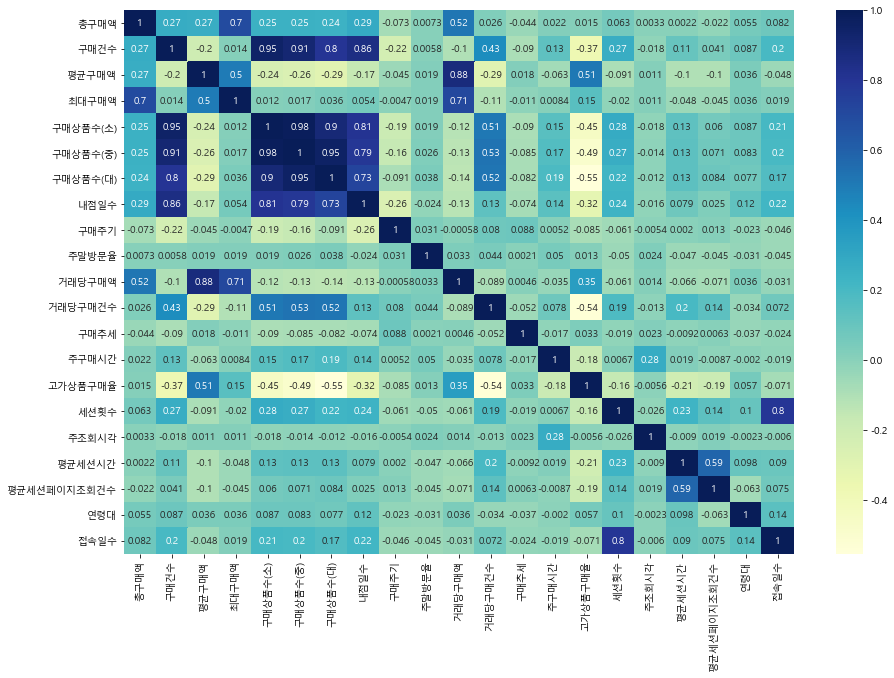

In [33]:
plt.figure(figsize=(15,10))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

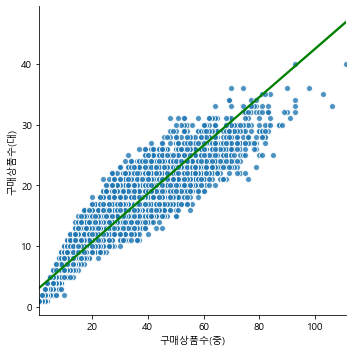

In [35]:
sns.lmplot(x='구매상품수(중)', y='구매상품수(대)', data=features, 
           line_kws={'color':"green"}, scatter_kws={'edgecolor':"white"})
plt.show()

In [36]:
del features['구매상품수(소)'], features['구매상품수(대)']

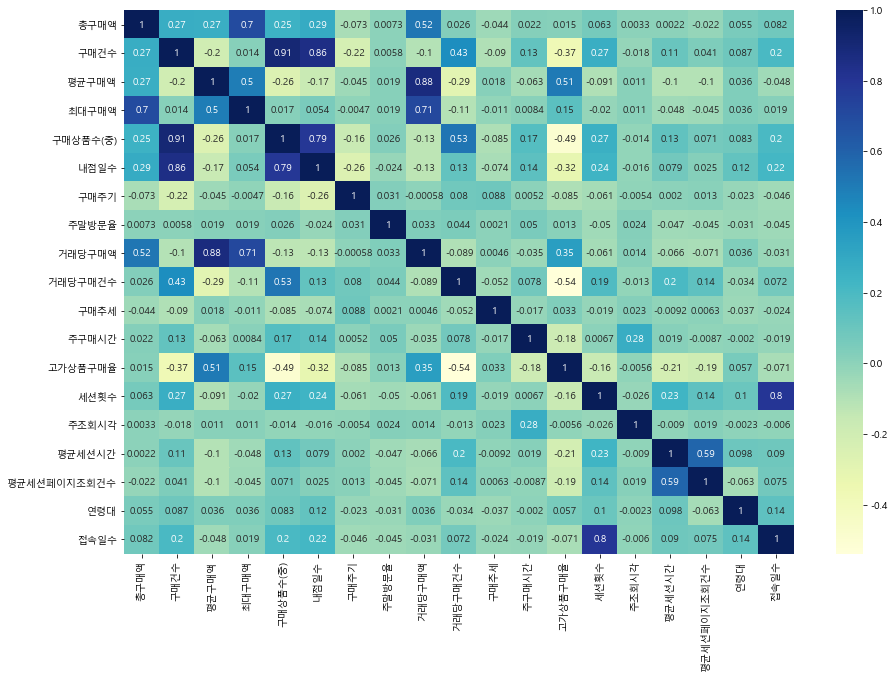

In [37]:
plt.figure(figsize=(15,10))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

#### Cluster Analysis

##### 데이터표준화

In [39]:
features = features.query('평균세션시간 != "NaN"')
features.isna().sum()

clnt_id        0
총구매액           0
구매건수           0
평균구매액          0
최대구매액          0
구매상품수(중)       0
내점일수           0
구매주기           0
주말방문율          0
거래당구매액         0
거래당구매건수        0
구매추세           0
주구매시간          0
고가상품구매율        0
세션횟수           0
주조회시각          0
평균세션시간         0
평균세션페이지조회건수    0
연령대            0
접속일수           0
dtype: int64

In [41]:
X = features.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std(), axis=1) 
X

,총구매액,구매건수,평균구매액,최대구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,세션횟수,주조회시각,평균세션시간,평균세션페이지조회건수,연령대,접속일수
0,4.012010,-0.326621,0.006452,0.426822,-0.326838,-0.327055,-0.326458,-0.327326,0.395896,-0.327207,-0.327312,-0.326187,-0.327326,-0.318320,-0.326621,-0.276543,-0.325970,-0.324613,-0.326784
1,4.112665,-0.261482,-0.229698,0.097350,-0.262071,-0.262226,-0.262323,-0.262348,-0.072129,-0.262311,-0.262347,-0.262252,-0.262349,-0.254152,-0.262239,-0.246026,-0.262006,-0.262025,-0.262032
2,4.116172,-0.258861,-0.222099,0.043580,-0.259292,-0.259390,-0.259477,-0.259499,-0.060606,-0.259470,-0.259498,-0.259445,-0.259499,-0.257553,-0.259445,-0.247687,-0.259232,-0.259281,-0.259417
3,4.107612,-0.267515,-0.224878,0.021686,-0.268156,-0.268528,-0.268550,-0.268640,0.096045,-0.268547,-0.268639,-0.268528,-0.268640,-0.261967,-0.268460,-0.249780,-0.267909,-0.268190,-0.268415
4,3.879307,-0.319645,-0.188492,1.174309,-0.319678,-0.319687,-0.319699,-0.319712,-0.072711,-0.319708,-0.319712,-0.319691,-0.319711,-0.319399,-0.319689,-0.317146,-0.319588,-0.319649,-0.319701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,1.884718,-0.506689,1.884718,1.884718,-0.506689,-0.506689,-0.506734,-0.506734,1.884718,-0.506689,-0.506736,-0.506281,-0.506689,-0.504198,-0.506236,-0.455599,-0.502612,-0.504469,-0.505828
11261,1.884826,-0.503995,1.884826,1.884826,-0.503995,-0.503995,-0.504026,-0.504026,1.884826,-0.503995,-0.504027,-0.503716,-0.503995,-0.503995,-0.503716,-0.485669,-0.503685,-0.502476,-0.503995
11262,1.884839,-0.503293,1.884839,1.884839,-0.503293,-0.503293,-0.503297,-0.503297,1.884839,-0.503293,-0.503297,-0.503255,-0.503293,-0.502747,-0.503230,-0.494224,-0.503159,-0.503171,-0.503209
11263,1.884842,-0.502834,1.884842,1.884842,-0.502834,-0.502834,-0.502841,-0.502841,1.884842,-0.502834,-0.502841,-0.502834,-0.502834,-0.502834,-0.502834,-0.499890,-0.502802,-0.502643,-0.502834


In [42]:
# 군집 수에 따른 SSE(군집내 오차제곱합)와 Silhouette score(군집간 분리도 - 군집내 응집도) 계산
wss = []
sis = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

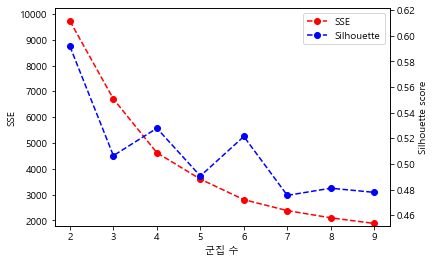

In [43]:
# 군집 수에 따른 SSE와 Silhouette score 시각화
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

C:\Users\Lee_HyeonJun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


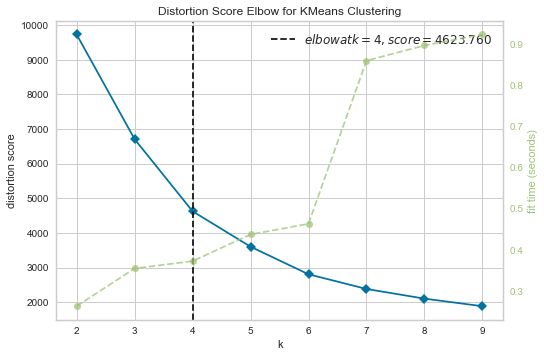

C:\Users\Lee_HyeonJun\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000233581A6E48>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [71]:
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))

C:\Users\Lee_HyeonJun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


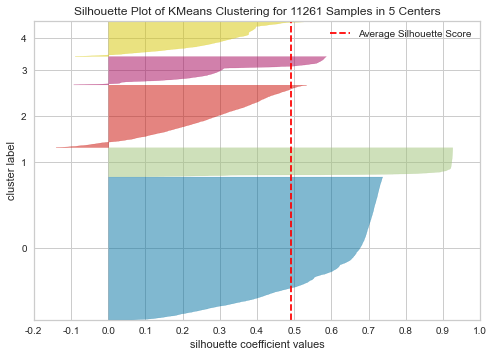

C:\Users\Lee_HyeonJun\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000217AEC72B00>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [44]:
# Silhouette diagram
# 높이: 군집의 크기, 넓이: 각 군집에 포함된 샘플의 정렬된 실루엣 계수, 점선: 실루엣 점수  
# 각 군집의 샘플 대부분이 실루엣 점수를 초과하면 군집의 수가 적당한 것으로 판단

from yellowbrick.cluster import silhouette_visualizer

silhouette_visualizer(KMeans(5, random_state=0), X, colors='yellowbrick')

In [45]:
best_k = 5

*군집분석을 통한 고객 세분화*

In [46]:
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [47]:
features['세그먼트'] = kmeans.labels_
features

C:\Users\Lee_HyeonJun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매액,...,구매추세,주구매시간,고가상품구매율,세션횟수,주조회시각,평균세션시간,평균세션페이지조회건수,연령대,접속일수,세그먼트
0,21922,79980,13,6152,13900,9,5,16,0.00,13330.0,...,0.27,21,0.00,166,13,936.0,25.0,50,10,0
1,39423,676262,134,5047,55600,43,19,4,0.09,29403.0,...,0.32,15,0.01,1267,17,2523.0,53.0,50,49,0
2,18362,802720,117,6861,55600,38,20,4,0.00,36487.0,...,0.22,10,0.00,357,10,2167.0,49.0,40,15,0
3,48969,388898,100,3889,25800,43,10,8,0.00,32408.0,...,0.16,10,0.00,593,16,1676.0,65.0,40,20,0
4,18478,1998300,32,62447,711000,16,12,6,0.03,117547.0,...,-0.27,10,0.16,149,11,1221.0,59.0,30,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11260,15146,52800,1,52800,52800,1,1,0,0.00,52800.0,...,-0.04,10,1.00,56,11,1129.0,91.0,50,20,1
11261,53632,77040,1,77040,77040,1,1,0,0.00,77040.0,...,-0.02,10,1.00,1,10,592.0,11.0,50,1,1
11262,58443,568000,1,568000,568000,1,1,0,0.00,568000.0,...,0.04,10,1.00,131,16,2158.0,33.0,30,21,1
11263,21232,362500,1,362500,362500,1,1,0,0.00,362500.0,...,0.04,1,1.00,1,1,448.0,6.0,30,1,1


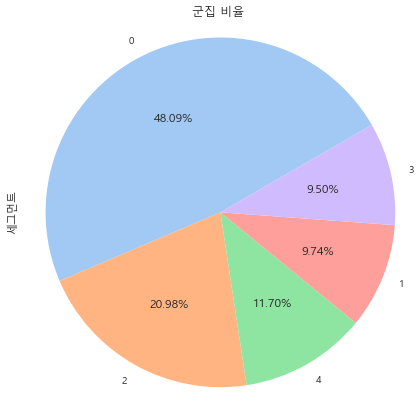

In [53]:
plt.figure(figsize=(6,6))
features.세그먼트.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal')
plt.show()

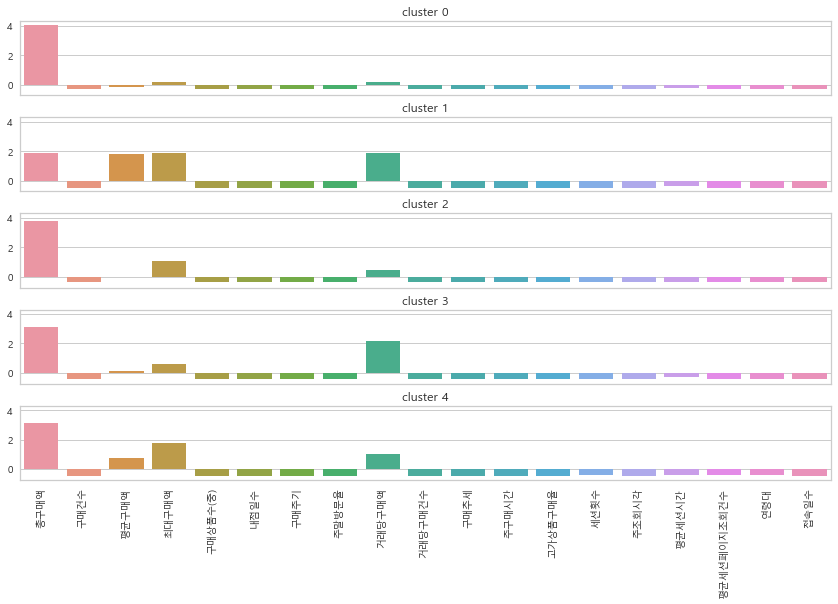

In [54]:
fig, ax = plt.subplots(best_k, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout() # 자동으로 레이아웃 조정
#plt.subplots_adjust(hspace=0.2) # subplot간의 너비 간격 조절

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
#    ax[i].bar(np.arange(X.columns.size), kmeans.cluster_centers_[i])
    sns.barplot(np.arange(X.columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(X.columns.size))
    ax[i].set_xticklabels(X.columns, rotation=90)

In [52]:
sns.set_palette("pastel")

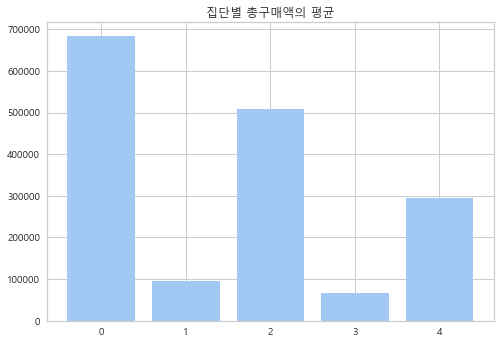

In [55]:
tot_pur_am = features.groupby('세그먼트')['총구매액'].mean().reset_index()
x = tot_pur_am['세그먼트']
y = tot_pur_am['총구매액']
plt.bar(x, y)
plt.title('집단별 총구매액의 평균')
plt.show()

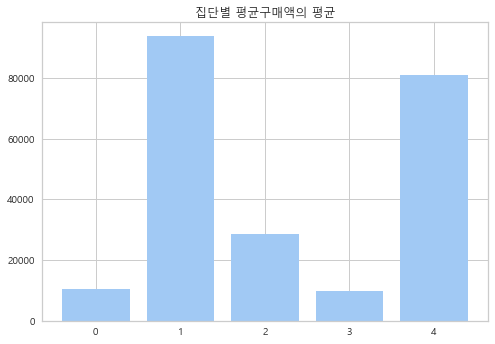

In [56]:
m_pur_am = features.groupby('세그먼트')['평균구매액'].mean().reset_index()
x = m_pur_am['세그먼트']
y = m_pur_am['평균구매액']
plt.bar(x, y)
plt.title('집단별 평균구매액의 평균')
plt.show()

In [57]:
seg = features[['clnt_id','세그먼트']]
df = pd.merge(df,seg,on = 'clnt_id',how = 'left');df

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3,price,세그먼트
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,10900.0,0.0
1,39423,105124,10,A03,0182,2019-09-20,17:26,21800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,10900.0,0.0
2,39423,89469,2,A03,0182,2019-09-01,03:32,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,12900.0,0.0
3,39423,88436,1,A03,0182,2019-08-30,17:15,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups,12900.0,0.0
4,18362,50872,3,A03,0182,2019-07-15,09:46,31600,4,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups,7900.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581749,53632,75835,1,A01,0258,2019-08-14,10:00,77040,2,M,50,Computers,Computer Accessories,Printer Inks / Toners,38520.0,1.0
581750,1499,92574,4,A01,1303,2019-09-04,08:09,29000,1,F,50,Sport Fashion,Women's Climbing Clothing,Women's Climbing Vests,29000.0,3.0
581751,58443,103525,1,A01,0263,2019-09-18,10:30,568000,1,F,30,Computers,Computers / Laptops,Tablet PCs,568000.0,1.0
581752,21232,103476,1,A01,0263,2019-09-18,01:38,362500,1,F,30,Computers,Computers / Laptops,Tablet PCs,362500.0,1.0


In [172]:
df.groupby('세그먼트')['clac_nm1'].apply(lambda x :x.value_counts()).reset_index().query('세그먼트 == 0.0')[:10]

,세그먼트,level_1,clac_nm1
0,0.0,Vegetables,60905
1,0.0,Snack Foods,50675
2,0.0,Dairy Products,40734
3,0.0,Meats,38657
4,0.0,Chilled Foods,38268
5,0.0,Substitute Foods,36300
6,0.0,Beverages,30235
7,0.0,Fruits,28981
8,0.0,Frozen Foods,26206
9,0.0,Spices / Seasonings,17774


In [173]:
df.groupby('세그먼트')['clac_nm1'].apply(lambda x :x.value_counts()).reset_index().query('세그먼트 == 1.0')[:10]

,세그먼트,level_1,clac_nm1
59,1.0,Cosmetics / Beauty Care,142
60,1.0,Women's Clothing,137
61,1.0,Fashion Accessories,105
62,1.0,Sport Fashion,74
63,1.0,Underwear / Socks and Hosiery / Homewear,50
64,1.0,Health Foods,48
65,1.0,Personal Care,45
66,1.0,Home / Kitchen Appliances,36
67,1.0,Detergents / Hygiene Goods,34
68,1.0,Beverages,34


In [169]:
df.groupby('세그먼트')['clac_nm1'].apply(lambda x :x.value_counts()).reset_index().query('세그먼트 == 2.0')[:10]

,세그먼트,level_1,clac_nm1
115,2.0,Vegetables,6655
116,2.0,Snack Foods,6650
117,2.0,Substitute Foods,4704
118,2.0,Dairy Products,4593
119,2.0,Chilled Foods,4397
120,2.0,Meats,4258
121,2.0,Beverages,3611
122,2.0,Fruits,3603
123,2.0,Frozen Foods,2962
124,2.0,Spices / Seasonings,2083


In [170]:
df.groupby('세그먼트')['clac_nm1'].apply(lambda x :x.value_counts()).reset_index().query('세그먼트 == 3.0')[:10]

,세그먼트,level_1,clac_nm1
174,3.0,Vegetables,1303
175,3.0,Snack Foods,1128
176,3.0,Substitute Foods,1125
177,3.0,Chilled Foods,939
178,3.0,Meats,886
179,3.0,Dairy Products,857
180,3.0,Fruits,670
181,3.0,Frozen Foods,665
182,3.0,Beverages,624
183,3.0,Spices / Seasonings,435


In [171]:
df.groupby('세그먼트')['clac_nm1'].apply(lambda x :x.value_counts()).reset_index().query('세그먼트 == 4.0')[:10]

,세그먼트,level_1,clac_nm1
227,4.0,Women's Clothing,458
228,4.0,Cosmetics / Beauty Care,408
229,4.0,Snack Foods,366
230,4.0,Vegetables,341
231,4.0,Substitute Foods,296
232,4.0,Meats,286
233,4.0,Fashion Accessories,275
234,4.0,Chilled Foods,265
235,4.0,Dairy Products,256
236,4.0,Personal Care,237


In [58]:
df = df.query('세그먼트 != "NaN"')

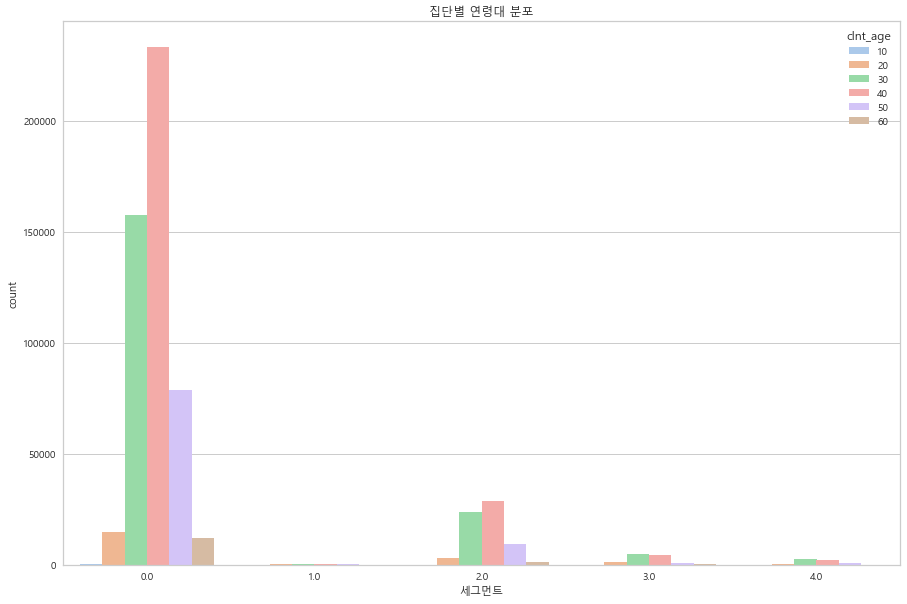

In [70]:
plt.figure(figsize = (15,10))
sns.countplot(data = df, x = '세그먼트', hue = 'clnt_age')
plt.title('집단별 연령대 분포')
plt.show()

In [63]:
df['on_off'] = df.biz_unit.apply(lambda x : x[:1])

C:\Users\Lee_HyeonJun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


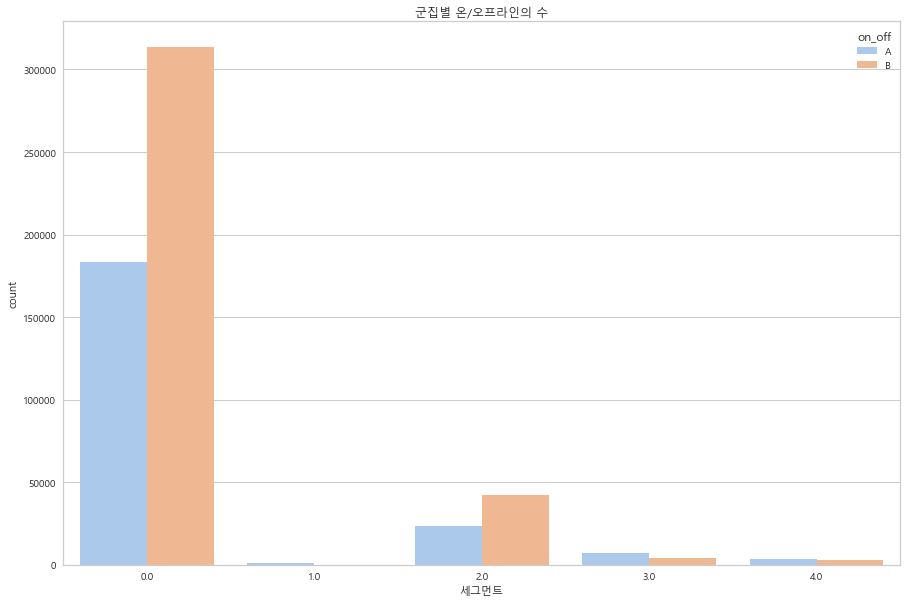

In [72]:
plt.figure(figsize = (15,10))
sns.countplot(data = df, x = '세그먼트', hue = 'on_off')
plt.title('군집별 온/오프라인의 수')
plt.show()

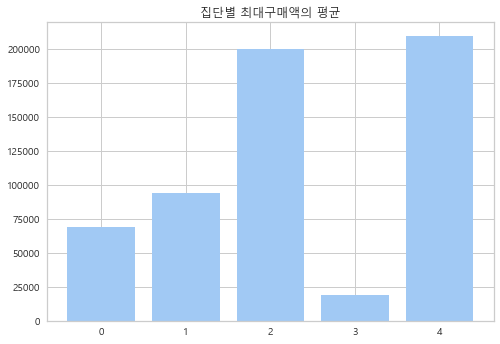

In [65]:
max_am = features.groupby('세그먼트')['최대구매액'].mean().reset_index()
x = max_am['세그먼트']
y = max_am['최대구매액']
plt.bar(x, y)
plt.title('집단별 최대구매액의 평균')
plt.show()

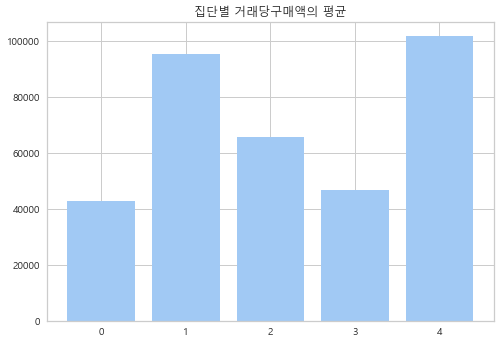

In [66]:
pur_am = features.groupby('세그먼트')['거래당구매액'].mean().reset_index()
x = pur_am['세그먼트']
y = pur_am['거래당구매액']
plt.bar(x, y)
plt.title('집단별 거래당구매액의 평균')
plt.show()